# Example of the stationary bootstrap algorithm in practice

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

## Goal

The goal of this workbook is to demonstrate the use of the stationary bootstrap algorithm. In this example, 3 new samples are generated.

In [2]:
nSample = 3 # Number of generated samples

EURO denominated 6M interest-rate-swap rate obtained from https://www.teleborsa.it/Quotazioni/Tassi/Eurirs for date 12/11/2021 and interpolated using the Smith & Wilson algorithm for missing durations.

In [3]:
swap = pd.DataFrame({'Swap rate': [-0.00497999999999998,
-0.00336999999999998,
-0.00219000000000003,
-0.00137999999999994,
-0.000839999999999952,
-0.000349999999999961,
0.000140000000000029,
0.000669999999999948,
0.00116999999999989,
0.00165999999999999,
0.00208999999999993,
0.00245999999999991,
0.00277690952371801,
0.00303541131903184,
0.00323000000000007,
0.00336225372994803,
0.00345212702349018,
0.00351682745133952,
0.00356726077755898,
0.00360999999999989,
0.00364393467821089,
0.00365001038370538,
0.00360991273768496,
0.00350996855727703,
0.00333999999999990,
0.00310968998405592,
0.00288888447388769,
0.00274107227669318,
0.00271077735186531,
0.00283000000000011]})

In [4]:
swap.head()

,Swap rate
0,-0.00498
1,-0.00337
2,-0.00219
3,-0.00138
4,-0.00084


In [5]:
sampleLen = swap.size; # Length of the sample will be the same as the input. 

The swap rates cann ot be stacked in a sampling algorithm therefore, they are used to   Vector with the 1-year forward curve. Convert rates into 1-year forward curve

Note that you loose 1 degree of freedom when converting from rates to 1-year-forward rates using the formula

$$ fwd(t) = \frac{(1 + r_{SWAP}(0, t+1))^{t+1}}{(1 + r_{SWAP}(0, t))^{t}} $$

In [6]:
forwards = np.zeros((sampleLen-1,1)) 

In [7]:
for iTime in range(0,sampleLen-1): 
    forwards[iTime][0] = np.power(1 + swap["Swap rate"][iTime+1],iTime+1) / np.power(1+swap["Swap rate"][iTime], iTime) - 1

In [8]:
forwards = pd.DataFrame(forwards, columns={'Forward rate'})

In [9]:
forwards.head()

,Forward rate
0,-0.003370
1,-0.001009
2,0.000242
3,0.000782
4,0.001612


Calculated using the method presented in 2004 paper by Politis & White.

In [10]:
m = 3.8299

Generate Stationary bootstraped samples

In this step, the samples are generated by repeatedly calling th StationaryBootstrap function. These samples are then saved into the Samples array

In [11]:
from StationaryBootstrap import StationaryBootstrap
for iSample in range(0, nSample):
    if iSample == 0:
        Samples = np.array(StationaryBootstrap(forwards.values,m,sampleLen))
    else:
        Samples = np.append(Samples, np.array(StationaryBootstrap(forwards.values,m,sampleLen)),axis=1)

In [12]:
Samples = pd.DataFrame(Samples)
Samples.head()

,0,1,2
0,0.002768,0.006270,-0.000561
1,-0.002402,0.006143,-0.002402
2,0.006270,0.005763,-0.002615
3,-0.001009,0.005216,-0.001094
4,0.004553,0.004801,0.004380


<IPython.core.display.Javascript object>


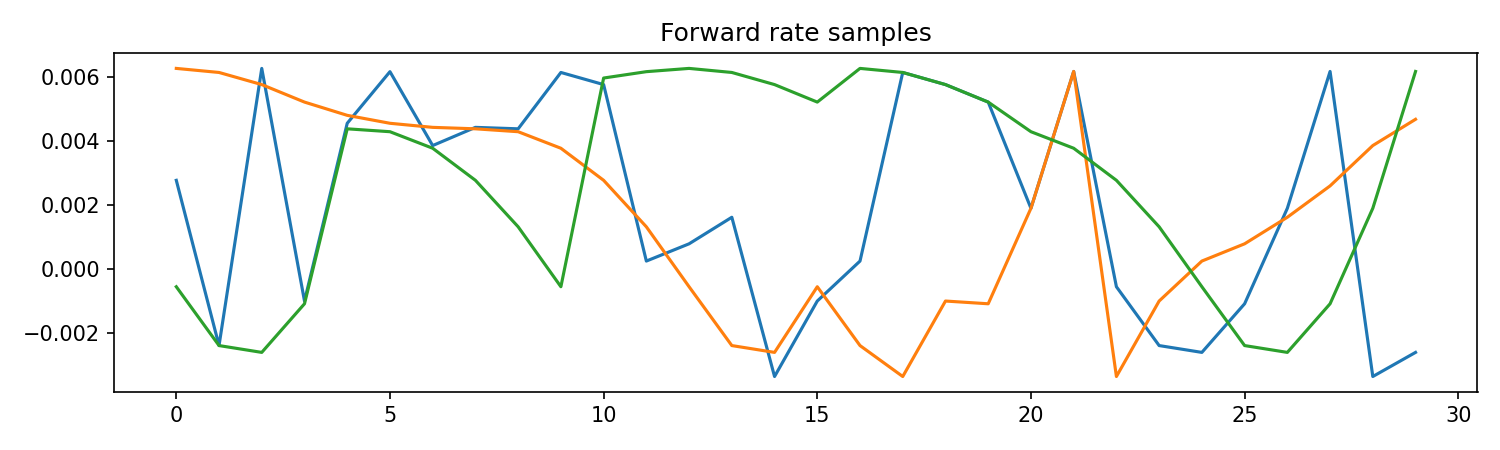

In [13]:
plot_data = Samples.copy().to_numpy()
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(plot_data) 
ax.set_title('Forward rate samples')
fig.tight_layout()